In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The purpose of this notebook is to establish a basic econometric library for the course Econometrics II, and specifically to create a framework for replicating OxMetrics functionalities in Python.

The dataset for the assignment consists of two variables: Real net investments, divided by housing stock the previous quarter and Q; the house prices divided by residential investment (2010=1).
The dataset spans 1971Q1-2023Q1 (see Assignment_2.csv), and the goal is to analyze the dynamic relationship between changes in residential investments and Tobinís Q, in particular if movements in Tobinís Q drive residential investments or if it is the other way around. Discuss the dynamic relationship, and if there are signs of a contemporaneous
relationship between the variables.

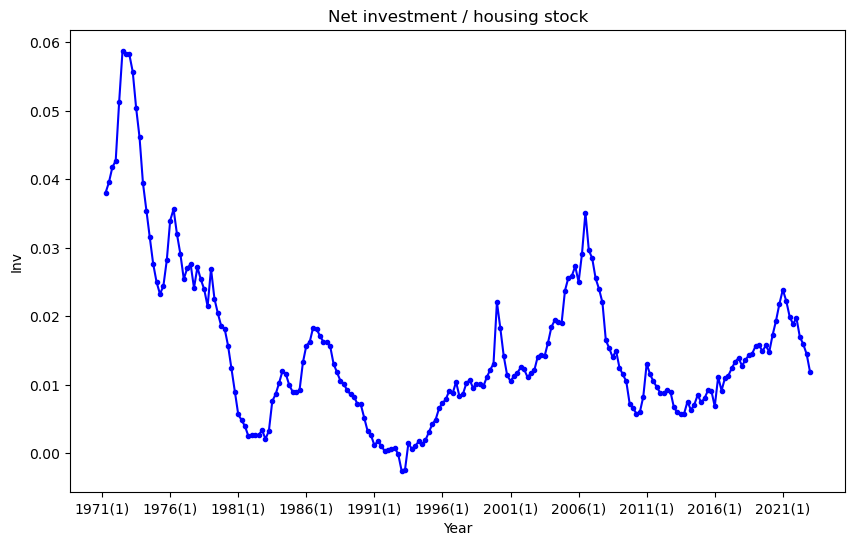

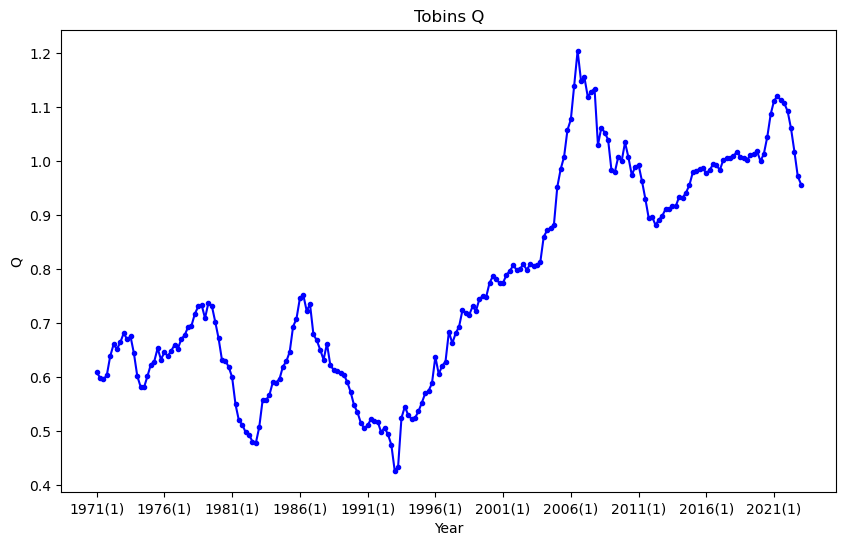

In [72]:
data = pd.read_csv("Assignment_2.csv")

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(data['Quarter'], data['Inv'], marker='.', linestyle='-', color='b')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Inv')
plt.title('Net investment / housing stock')
plt.xticks(data['Quarter'][::20])
# Show the plot
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(data['Quarter'], data['Q'], marker='.', linestyle='-', color='b')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Q')
plt.title('Tobins Q')
plt.xticks(data['Quarter'][::20])

# Show the plot
plt.show()


Now these are clearly not stationary, so we use the hint given in the assignment and make the following transformations:
$$\Delta_4Inv_t=Inv_t-Inv_{t-4}$$
$$\Delta_4Q_t=Q_t-Q_{t-4}$$

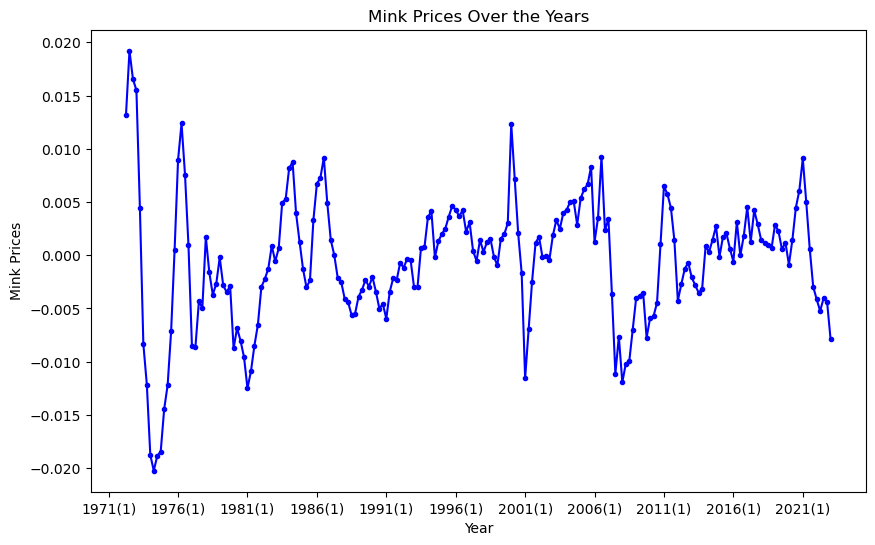

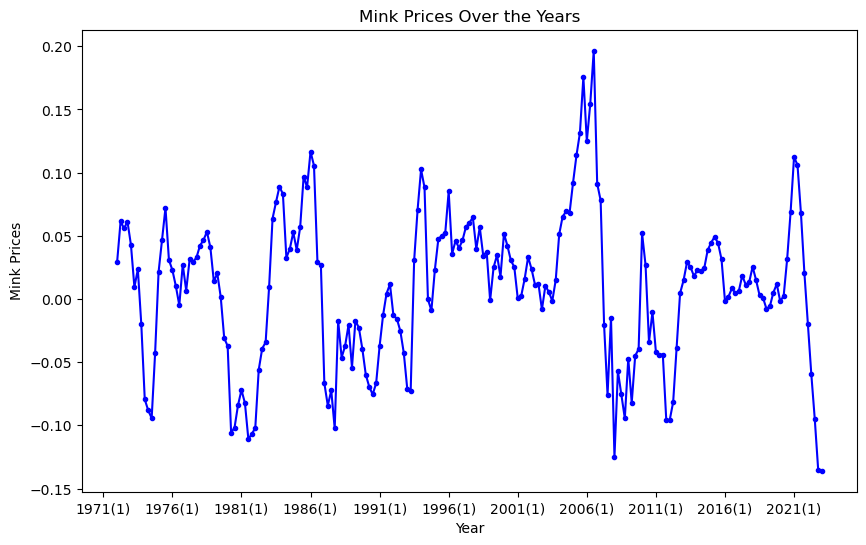

In [73]:
data['Diff4_Inv'] = data['Inv'].diff(4)  # 4th difference for year-over-year change
data['Diff4_Q'] = data['Q'].diff(4)  # 4th difference for year-over-year change

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(data['Quarter'], data['Diff4_Inv'], marker='.', linestyle='-', color='b')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Mink Prices')
plt.title('Mink Prices Over the Years')
plt.xticks(data['Quarter'][::20])
# Show the plot
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(data['Quarter'], data['Diff4_Q'], marker='.', linestyle='-', color='b')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Mink Prices')
plt.title('Mink Prices Over the Years')
plt.xticks(data['Quarter'][::20])

# Show the plot
plt.show()


Now let's test if they are stationary with an ADF test.

In [74]:
from statsmodels.tsa.stattools import adfuller
data = data.dropna()
adfuller(data['Diff4_Inv'])

(-3.779127896390756,
 0.0031282302347524875,
 13,
 190,
 {'1%': -3.4652439354133255,
  '5%': -2.8768752281673717,
  '10%': -2.574944653739612},
 -1752.2026424239668)

In [75]:
adfuller(data['Diff4_Q'])

(-3.8431173136565,
 0.002495727294413957,
 13,
 190,
 {'1%': -3.4652439354133255,
  '5%': -2.8768752281673717,
  '10%': -2.574944653739612},
 -823.3130305439629)

The test statistics are (for Inv and Q respectively) -3.78 and -3.84 and the corresponding p-values are 0.003 and 0.002, which are both under the 5% threshold, so we reject the null-hypothesis of the time series being non-stationary and conclude that they are stationary.

Next, let's look at the ACF and PACF plots of the figures. While not as useful, they can still give an indication as to how many lags should be included.

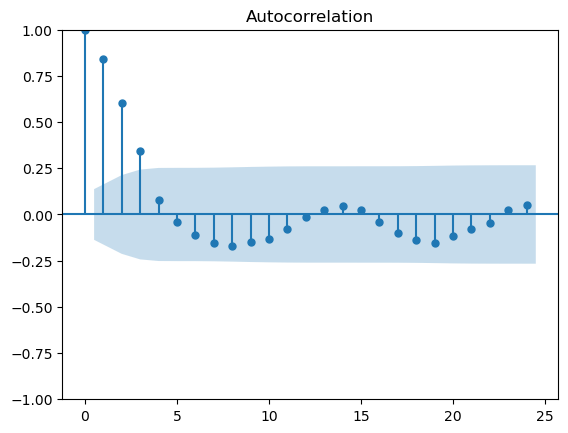

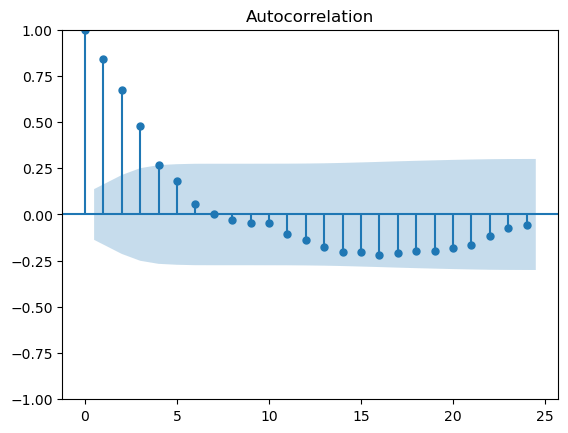

In [76]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(data['Diff4_Inv'])
plot_acf(data['Diff4_Q'])
plt.show()


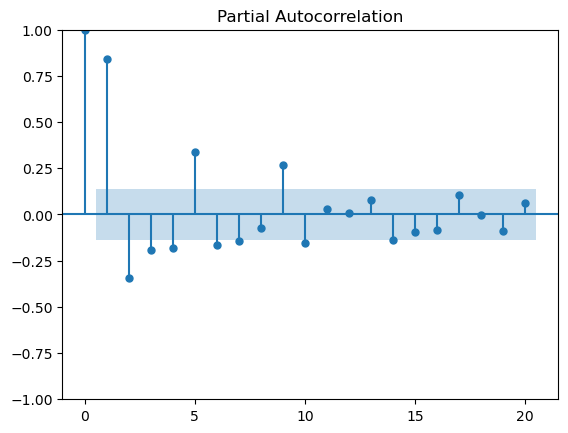

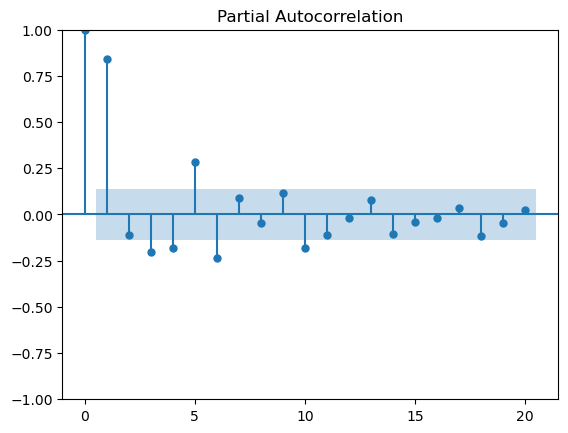

In [77]:
pacf_Diff4_Inv = pacf(data['Diff4_Inv'], nlags=20)
pacf_Diff4_Q = pacf(data['Diff4_Q'], nlags=20)

plot_pacf(data['Diff4_Inv'], lags=20)
plot_pacf(data['Diff4_Q'], lags=20)  # Change lags according to your data
plt.show()


As we see quite a lot of significant lags, we can run a VAR(20) model and use GETS modeling (General-to-specific) to choose the approprite amount of lags.

*Note: should use heteroskedastisticity-consistent standard errors (HCSE), to correct for heteroskedasticity. This is not implemented directly in the VAR function in statsmodels at the moment.*

In [80]:
from statsmodels.tsa.api import VAR
import statsmodels.api as sm

VAR_data = data[['Diff4_Inv', 'Diff4_Q']]
VAR_model = VAR(VAR_data)
results = VAR_model.fit(maxlags=13, method='ols')
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 25, Oct, 2024
Time:                     19:53:30
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -18.5664
Nobs:                     191.000    HQIC:                  -19.1135
Log likelihood:           1372.87    FPE:                3.45967e-09
AIC:                     -19.4859    Det(Omega_mle):     2.65576e-09
--------------------------------------------------------------------
Results for equation Diff4_Inv
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.000031         0.000187            0.167           0.867
L1.Diff4_Inv          0.987770         0.081755           12.082           0.000
L1.Diff4_Q            0.004704         0.006711         

c:\Users\victo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
